In [1]:
%load_ext autoreload

In [2]:
import math
import numpy as np

import torch
from torch import nn
from torch import distributions

import numpy as np
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
%autoreload 2
from model import SimpleNet, ModelOutput, Energy
from samplers import losses
from buffers import ReplayBuffer
from datasets_2d import DatasetSampler, GaussMix
from ema import EMA

from samplers.utils import sample_trajectory
from utils import plot_trajectory

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ], device=mean.device)
    return (R @ mean.T).T


def scatter(tensor, alpha=1.0, label=None):
    plt.scatter(tensor[:, 0], tensor[:, 1], alpha=alpha, label=label)


@torch.no_grad()
def draw_level_lines(func, samples=None, lims=(-2, 2), nsamples: int = 100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)  # Shape: [100, 100, 2]

    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    Z = func(grid_points).numpy()  # Shape: [100, 100]
    Z = Z.reshape(nsamples, nsamples)

    plt.figure()
    contour = plt.contour(X, Y, Z, levels=7, colors='k')  # Draw contour lines
    plt.clabel(contour, inline=True, fontsize=6)           # Add labels to contours
    plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)    
    if samples is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c='r')
    plt.colorbar(label='Function Value')                  # Add color bar
    plt.title('Level Lines of the Function')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


def get_drid(lims=(-5, 5), nsamples=100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)
    return torch.from_numpy(grid_points).reshape(-1, 2).float()

In [ ]:
def check_grad_is_nan(model, name):
    for n, p in model.named_parameters():
        if torch.isnan(p.grad).any():
            print(f"NaN in {n} grad of {name}")
            return True
    return False


class FixedSizeDataset:
    def __init__(self, dataset):
        self.dataset = dataset
        self.size = dataset.size(0)

    def sample(self, batch_size):
        idxs = torch.randint(0, self.size, (batch_size,))
        return self.dataset[idxs]

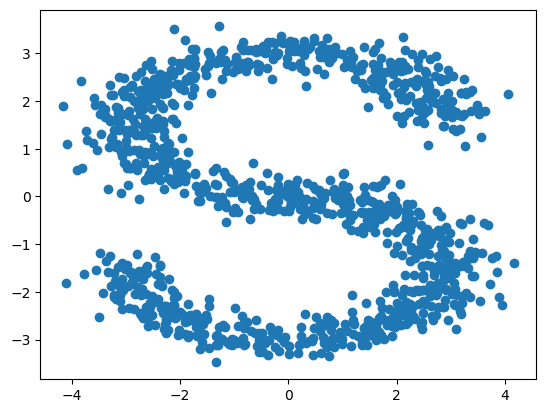

In [12]:
sampler = DatasetSampler(
    p_0='s_curve', p_0_args=[None, 0.15, 3],
    p_1='two_moons', p_1_args=[None, 0.05, 3],
)

x_0, x_1 = sampler.sample(128 * 9)

scatter(x_0)
# scatter(x_1)

In [14]:
@torch.no_grad()
def plot_training_summary(energy, fwd_model, sampler, fwd_losses, 
                          bwd_losses, energy_losses, dt, 
                          n_steps, t_max, noise_std, n_samples=512):
    fig = plt.figure(figsize=(16, 16))
    
    # Create grid spec for custom layout
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 0.7, 0.7])
    
    # Plot 1: Samples x_0 and x_1
    ax1 = fig.add_subplot(gs[0, 0])
    with torch.no_grad():
        x_0, _ = sampler.sample(n_samples)
        x_0n = x_0 + torch.randn_like(x_0) * noise_std
        x_1 = sample_trajectory(fwd_model, x_0n, "forward", dt, n_steps, t_max, only_last=True)
    
    ax1.scatter(x_0[:, 0], x_0[:, 1], alpha=0.5, label='x_0', color='blue')
    ax1.scatter(x_1[:, 0], x_1[:, 1], alpha=0.5, label='x_1', color='red')
    ax1.legend()
    ax1.set_title('Samples x_0 and x_1')
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)
    
    # Plot 2: Energy function
    ax2 = fig.add_subplot(gs[0, 1])
    limits = (-5, 5)
    x = np.linspace(*limits, 200)
    y = np.linspace(*limits, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X, Y], axis=-1)
    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    
    with torch.no_grad():
        log_density = -energy(grid_points).detach()
        # log_density = log_density.exp()
        log_density = torch.clamp(log_density - log_density.max(), -50, None)
    
    Z = log_density.numpy().reshape(200, 200)
    
    contour = ax2.contour(X, Y, Z, levels=7, colors='k')
    ax2.clabel(contour, inline=True, fontsize=6)
    im = ax2.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)
    ax2.set_title('- E(x)')
    fig.colorbar(im, ax=ax2, label='Energy Value')
    ax2.set_xlim(*limits)
    ax2.set_ylim(*limits)
    
    # Plot 3: Forward losses
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(fwd_losses)
    ax3.set_title('Forward Losses')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Loss')
    ax3.grid(True)
    if min(fwd_losses) < -10 or max(fwd_losses) > 100:
        ax3.set_yscale('symlog')
        ax3.set_ylabel('Loss (symlog scale)')
    
    # Plot 4: Backward losses
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(bwd_losses)
    ax4.set_title('Backward Losses')
    ax4.set_xlabel('Iterations')
    ax4.set_ylabel('Loss')
    ax4.grid(True)
    if min(bwd_losses) < -10:
        ax4.set_yscale('symlog')
        ax4.set_ylabel('Loss (symlog scale)')
    
    # Plot 5: Energy losses
    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(energy_losses)
    ax5.set_title('Energy Losses')
    ax5.set_xlabel('Iterations')
    ax5.set_ylabel('Loss')
    ax5.grid(True)
    if min(energy_losses) < -10:
        ax5.set_yscale('symlog')
        ax5.set_ylabel('Loss (symlog scale)')
    
    plt.tight_layout()
    plt.show()


def plot_losses(fwd_losses, bwd_losses, energy_losses):
    """
    Plot the three loss curves in a single row.
    
    Args:
        fwd_losses: List of forward process losses
        bwd_losses: List of backward process losses
        energy_losses: List of energy function losses
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot forward losses
    axes[0].plot(fwd_losses)
    axes[0].set_title('Forward Losses')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    if min(fwd_losses) < -10 or max(fwd_losses) > 100:
        axes[0].set_yscale('symlog')
        axes[0].set_ylabel('Loss (symlog scale)')
    
    # Plot backward losses
    axes[1].plot(bwd_losses)
    axes[1].set_title('Backward Losses')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    if min(bwd_losses) < -10:
        axes[1].set_yscale('symlog')
        axes[1].set_ylabel('Loss (symlog scale)')
    
    # Plot energy losses
    axes[2].plot(energy_losses)
    axes[2].set_title('Energy Losses')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)
    if min(energy_losses) < -10:
        axes[2].set_yscale('symlog')
        axes[2].set_ylabel('Loss (symlog scale)')
    
    plt.tight_layout()
    return fig

True 0.08


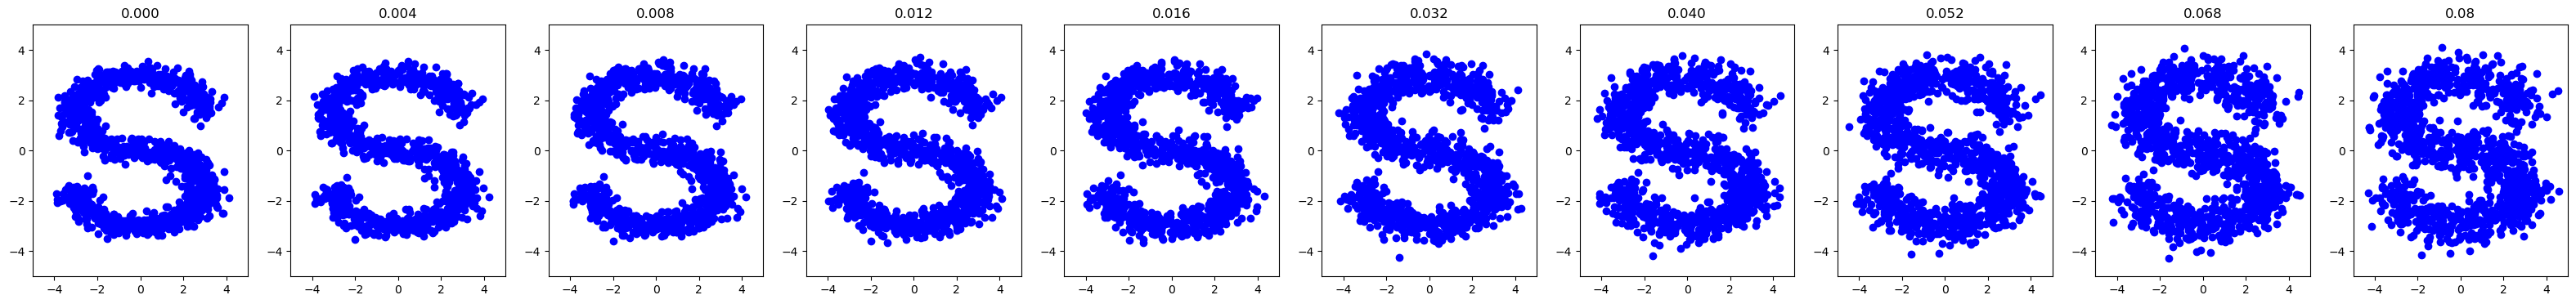

In [15]:
alpha = 0.24
dt = 0.004
t_max = 0.08
n_steps = 20


print(dt * n_steps == t_max, dt * n_steps)


def ref_process(x, t):
    return ModelOutput(drift=-alpha * x)


x_0, _ = sampler.sample(128 * 9)
trajectory, timesteps = sample_trajectory(ref_process, x_0, 'backward', dt, 
                                          n_steps, t_max, return_timesteps=True)

_ = plot_trajectory(trajectory, timesteps[::-1], 
                    indices=[0, 1, 2, 3, 4, 8, 10, -8, -4, -1],
                    limits=(-5, 5))

In [16]:
N_TRAJECTORIES = 2
BATCH_SIZE = 512
N_SB_STEPS = 10_000

energy = Energy(in_dim=2, out_dim=1, 
                hidden_dim=256, 
                n_blocks=1, 
                use_ln=False, 
                block_type='simple')

fwd_model = SimpleNet(64, in_dim=3, 
                      t_emb_size=None,
                      n_main_body_layers=1, 
                      predict_log_var=True)

bwd_model = SimpleNet(64, in_dim=3, 
                      t_emb_size=None,
                      n_main_body_layers=1,
                      predict_log_var=True)

energy_ema = EMA(energy, decay=0.999)
energy_optim = torch.optim.Adam(energy.parameters(), lr=2e-4)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=2e-4)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=1e-4)

num_bwd_iters = 5
num_fwd_iters = 5
num_energy_iters = 1

milestones = [3000, 8000]
gamma = 0.4


fwd_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    fwd_optim, 
    milestones=[ms * num_fwd_iters for ms in milestones], 
    gamma=gamma
)
bwd_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    bwd_optim, 
    milestones=[ms * num_bwd_iters for ms in milestones], 
    gamma=gamma
)
energy_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    energy_optim, 
    milestones=[ms * num_energy_iters for ms in milestones], 
    gamma=gamma
)

data_sampler = FixedSizeDataset(sampler.sample(1024)[0])
p1_buffer = ReplayBuffer(2048, update_fraction=1.0)

fwd_losses, bwd_losses, energy_losses = [], [], []
current_iter = 0

Iter=0, Energy Loss: -0.003, energy lr=0.0002 Forward Loss: -0.003, forward lr=0.0002  backward Loss: -0.003, backward lr=0.0001


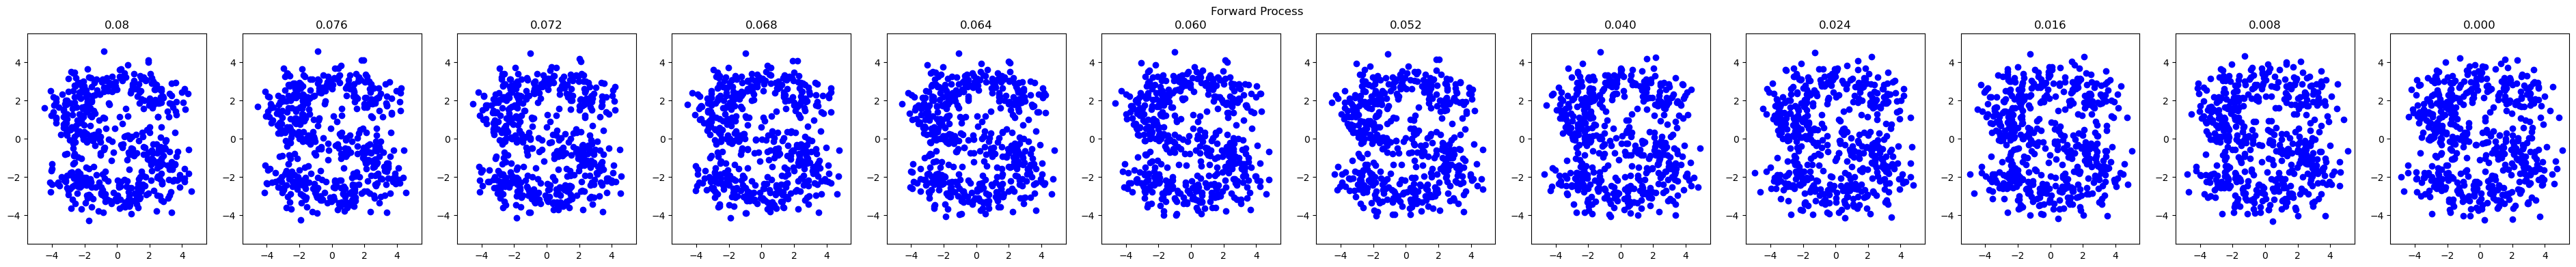

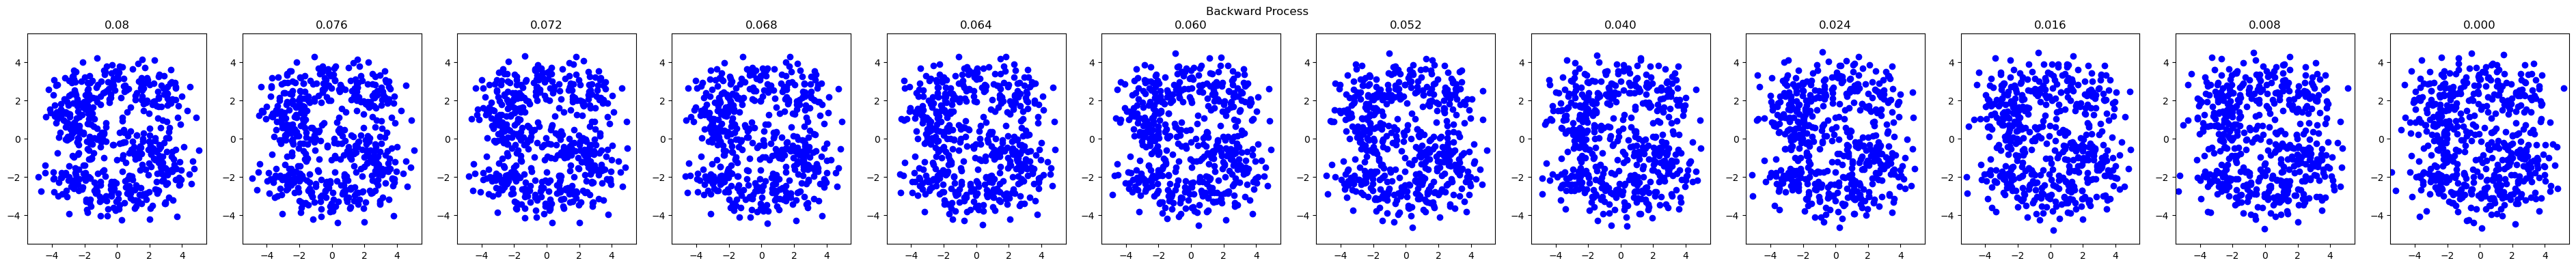

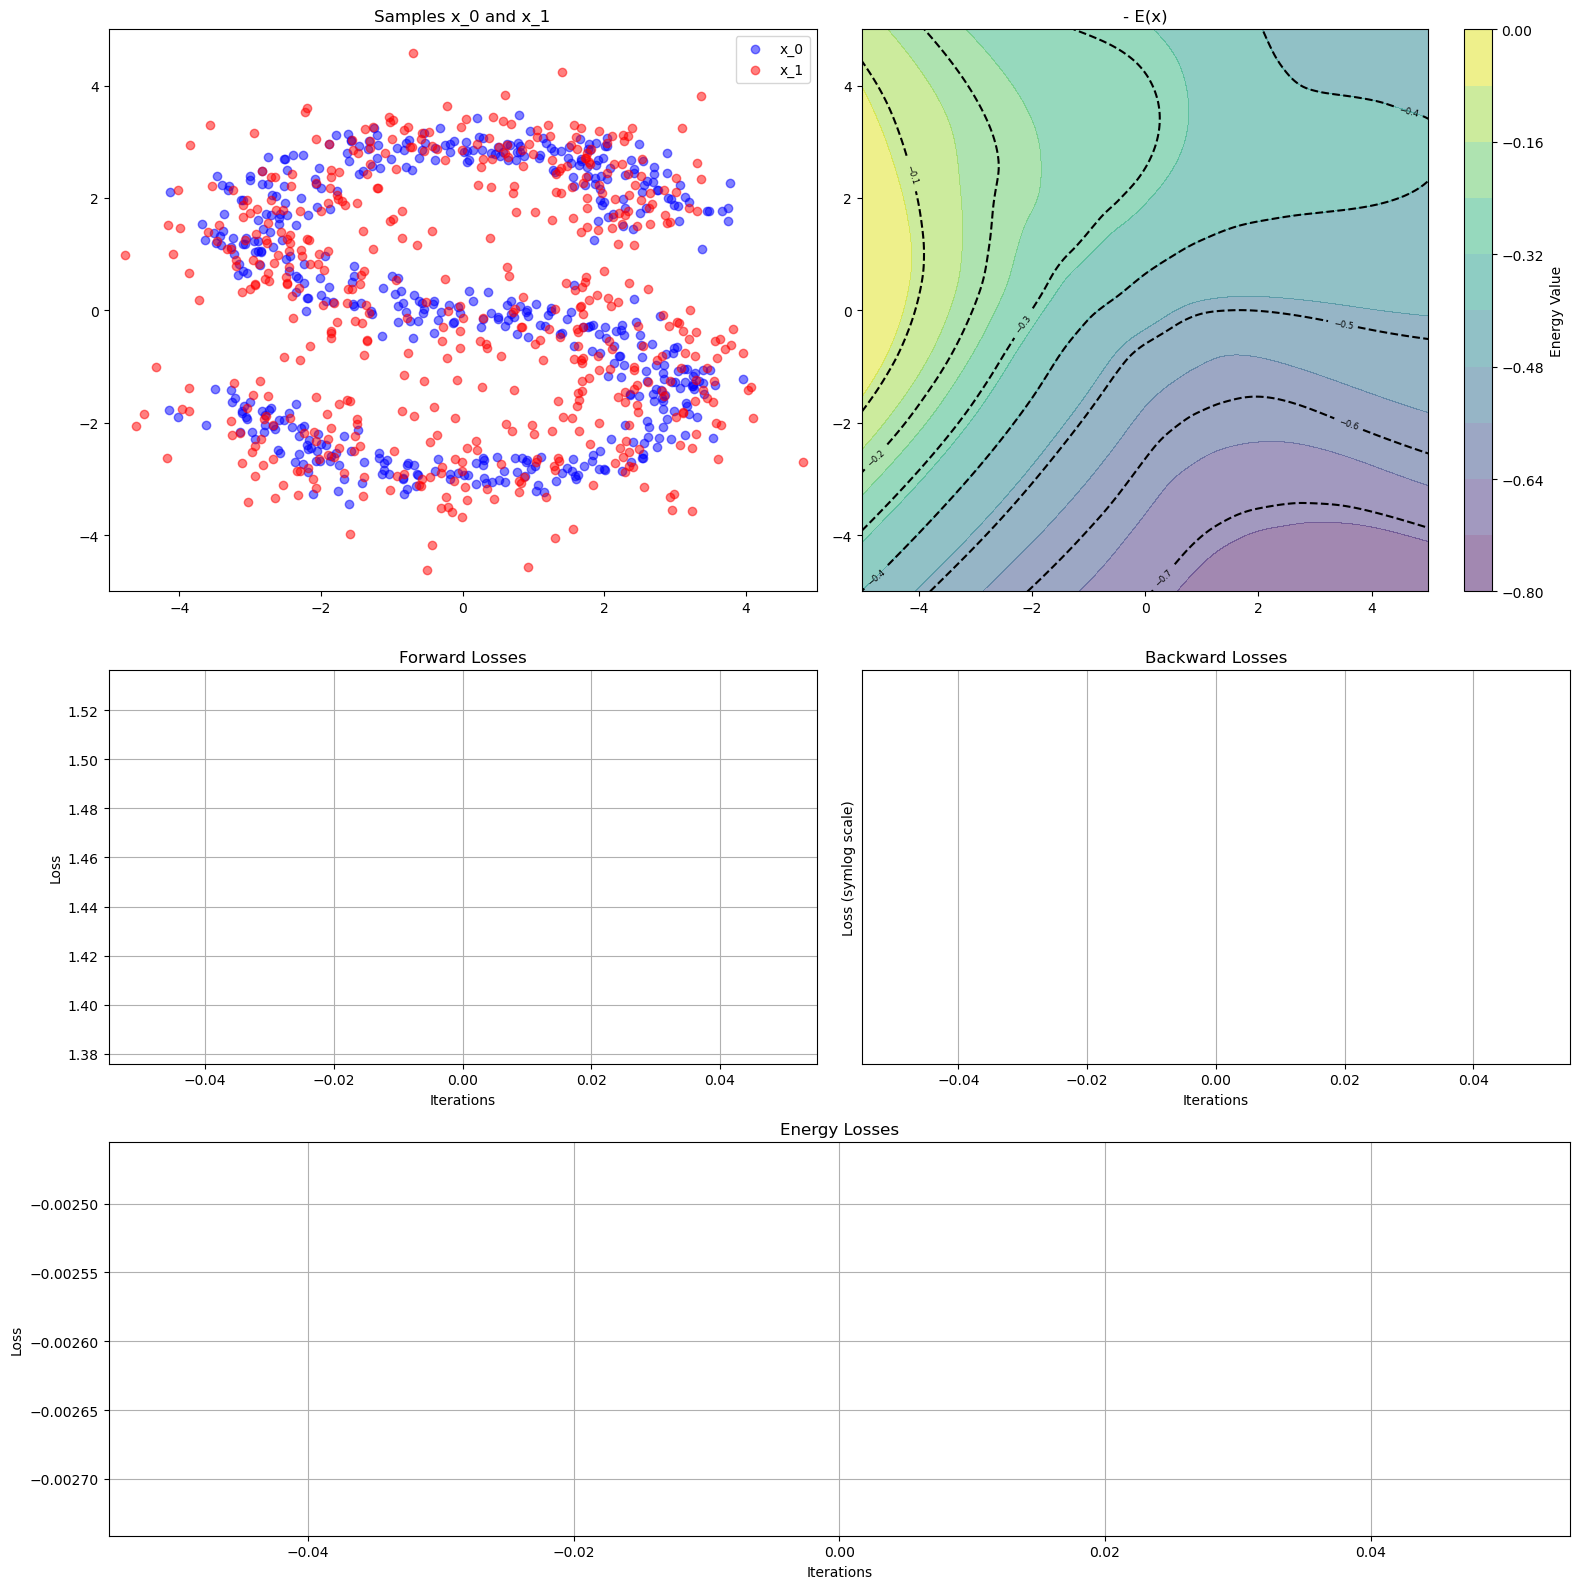

Iter=100, Energy Loss: 0.076, energy lr=0.0002 Forward Loss: 0.076, forward lr=0.0002  backward Loss: 0.076, backward lr=0.0001


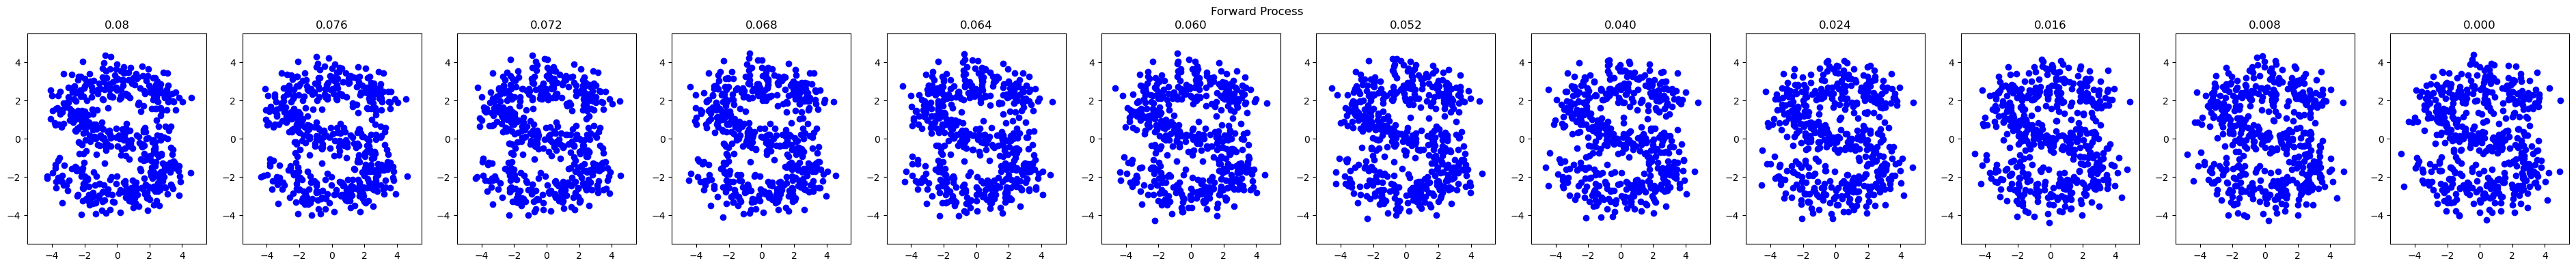

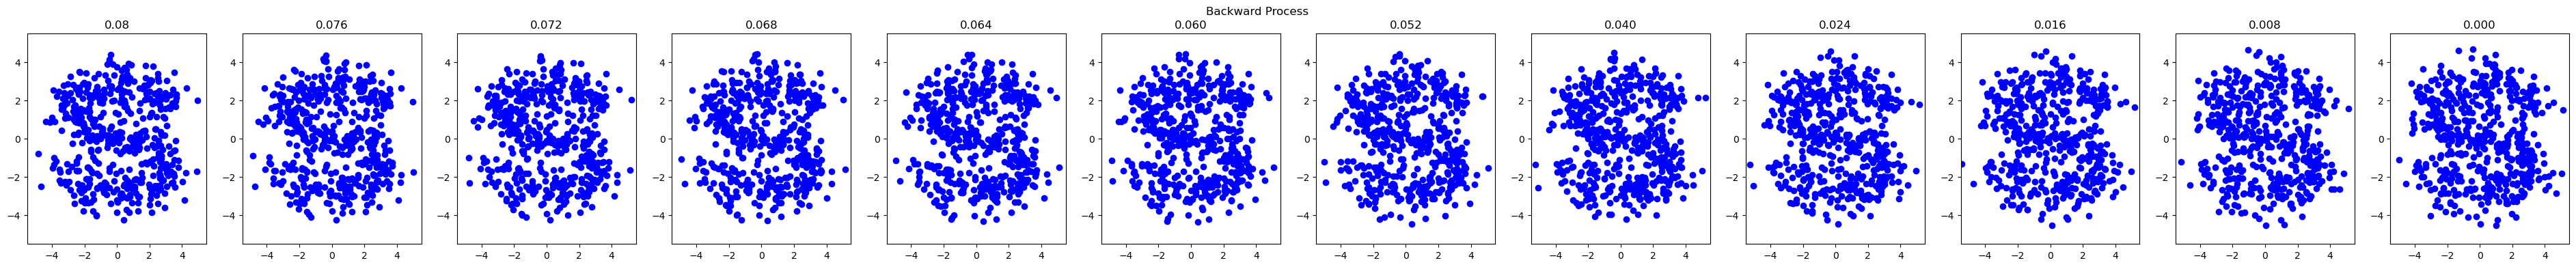

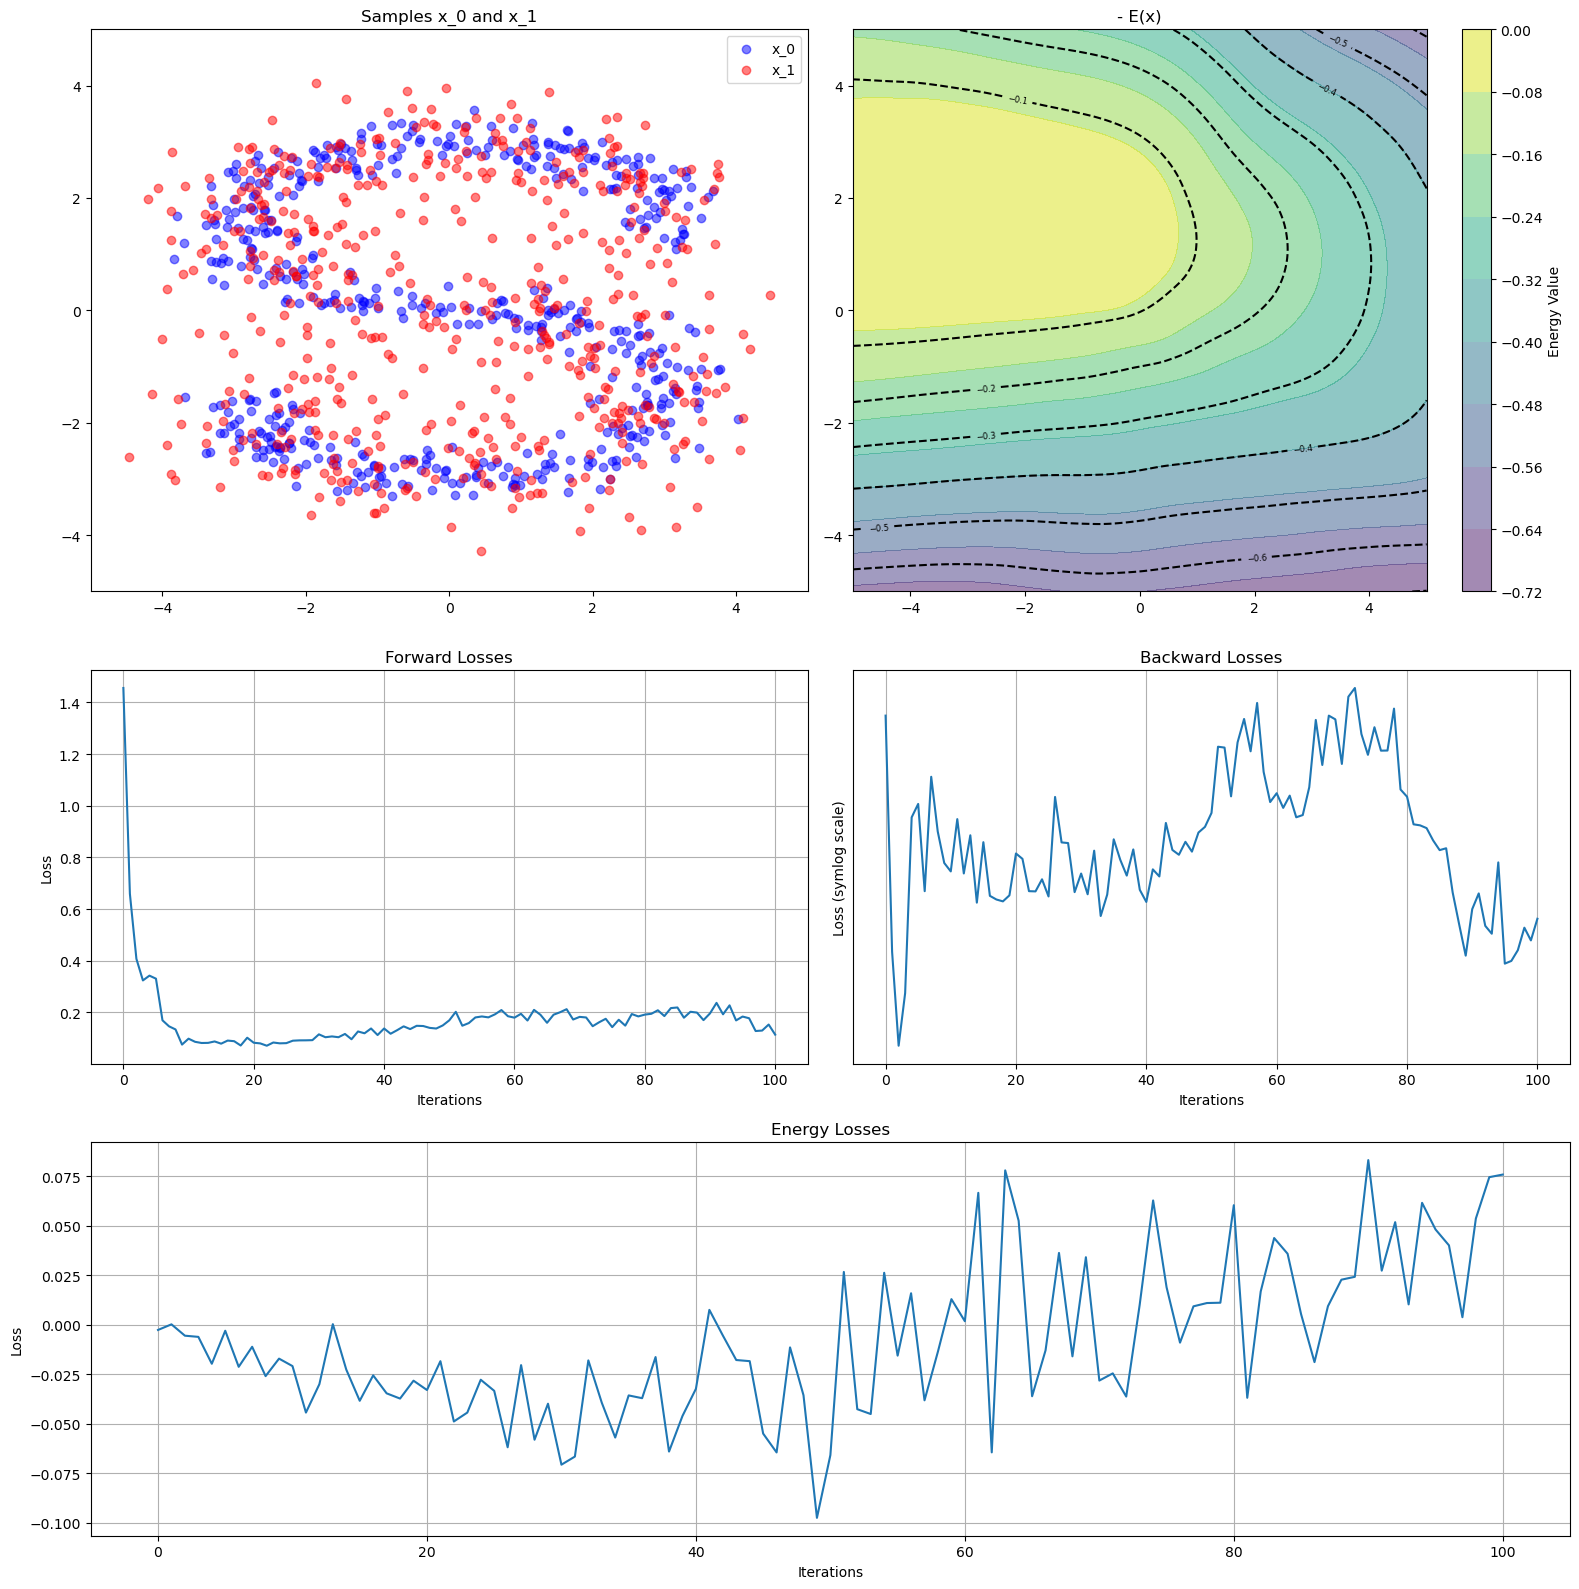

In [ ]:
seed_everything(3704)
logging_frequency = 100
noise_std = 0.5
use_buffer = False
resample_x_0 = True


for it in range(current_iter, 10_000):
    current_iter = it    
    x_train = data_sampler.sample(BATCH_SIZE)

    # TRAIN BACKWARD PROCESS
    for _ in range(num_bwd_iters):
        bwd_optim.zero_grad(set_to_none=True)

        if resample_x_0:
            x_train = data_sampler.sample(BATCH_SIZE)
        x_0 = x_train + torch.randn_like(x_train) * noise_std

        loss = losses.compute_bwd_tlm_loss(
            fwd_model, bwd_model, x_0, dt, t_max, n_steps
        )
       
        assert not torch.isnan(loss).any(), "backward loss is NaN"
        check_grad_is_nan(bwd_model, "bwd_model")
        
        bwd_optim.step()
        bwd_scheduler.step()
        
    bwd_losses.append(loss.item())

    # TRAIN FORWARD PROCESS
    for _ in range(num_fwd_iters):
        fwd_optim.zero_grad(set_to_none=True)

        if resample_x_0:
            x_train = data_sampler.sample(BATCH_SIZE)

        x_0 = x_train[:BATCH_SIZE // N_TRAJECTORIES].repeat(N_TRAJECTORIES, 1)
        x_0 = x_0 + torch.randn_like(x_0) * noise_std
        
        loss = losses.compute_fwd_vargrad_loss(
            fwd_model, bwd_model, lambda x: - energy(x),
            x_0, dt, t_max, n_steps, 
            p1_buffer=p1_buffer,
            n_trajectories=N_TRAJECTORIES,
            clip_range=(-10000, 10000)
        )
        
        assert not torch.isnan(loss).any(), "forward loss is NaN"
        loss.backward()
        check_grad_is_nan(fwd_model, "fwd_model")
        
        fwd_optim.step()
        fwd_scheduler.step()

    fwd_losses.append(loss.item())

    # TRAIN ENERGY FUNCTION
    for _ in range(num_energy_iters):
        if resample_x_0:
            x_train = data_sampler.sample(BATCH_SIZE)

        if use_buffer:
            x_1 = p1_buffer.sample(BATCH_SIZE)
        else:
            x_train_noisy = x_train + torch.randn_like(x_train) * noise_std
            x_1 = sample_trajectory(fwd_model, x_train_noisy, "forward", dt, 
                                    n_steps, t_max, only_last=True)

        energy_optim.zero_grad(set_to_none=True)
        loss = losses.ebm_loss(energy, x_train, x_1, alpha=0.01, reg_type='l2')

        assert not torch.isnan(loss).any(), "energy loss is NaN"
        loss.backward()
        check_grad_is_nan(energy, "energy")

        energy_optim.step()
        energy_ema.update()
        energy_scheduler.step()
    
    energy_losses.append(loss.item())

    # LOG ENERGY FUNCTION
    limits = (-5, 5)
    if it % logging_frequency == 0:
        # clear_output(wait=True)
        print(
            f"Iter={it}, Energy Loss: {loss.item():.3f},", 
            f"energy lr={energy_optim.param_groups[0]['lr']} "
            f"Forward Loss: {loss.item():.3f},", 
            f"forward lr={fwd_optim.param_groups[0]['lr']} ",
            f"backward Loss: {loss.item():.3f},", 
            f"backward lr={bwd_optim.param_groups[0]['lr']}",
        )
        
        with torch.no_grad():
            x_0, _ = sampler.sample(BATCH_SIZE)
            x_0 = x_0 + torch.randn_like(x_0) * noise_std
            
            fwd_trajectory, timesteps = sample_trajectory(
                fwd_model, x_0, "forward", dt, 
                n_steps, t_max, return_timesteps=True
            )
            bwd_trajectory, timesteps = sample_trajectory(
                bwd_model, fwd_trajectory[-1], "backward", 
                dt, n_steps, t_max, return_timesteps=True
            )

        fig_fwd = plot_trajectory(
            fwd_trajectory, timesteps, 
            indices=[0, 1, 2, 3, 4, 5, 7, 10, -7, -5, -3, -1], 
            title="Forward Process", limits=(-5.5, 5.5)
        )
        plt.show()
        fig_bwd = plot_trajectory(
            bwd_trajectory, timesteps, 
            indices=[0, 1, 2, 3, 4, 5, 7, 10, -7, -5, -3, -1],
            title="Backward Process", limits=(-5.5, 5.5)
        )
        plt.show()    

        energy_ema.apply_shadow()

        plot_training_summary(energy, fwd_model,sampler,
                              fwd_losses, bwd_losses, energy_losses, 
                              dt, n_steps, t_max, noise_std, n_samples=BATCH_SIZE)
        energy_ema.restore()

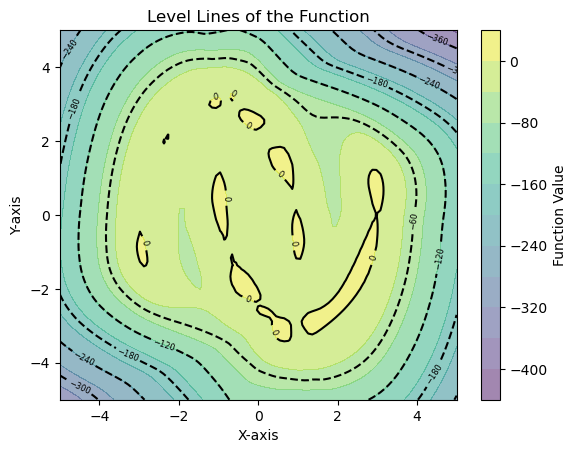

In [81]:
with torch.no_grad():
    draw_level_lines(lambda x: - energy(x), lims=(-5, 5))

Run langevin dynamics

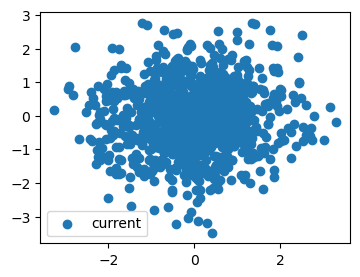

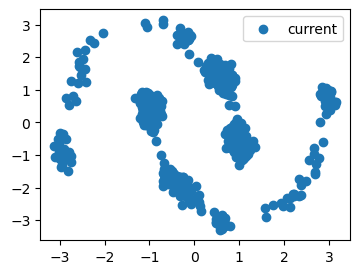

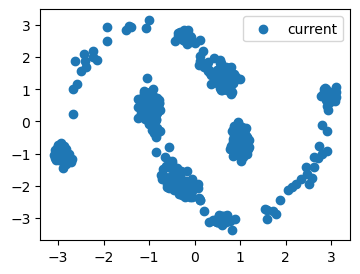

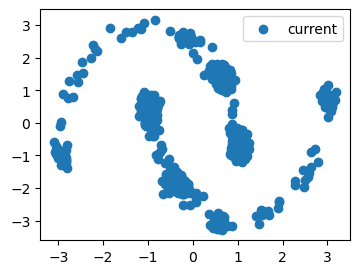

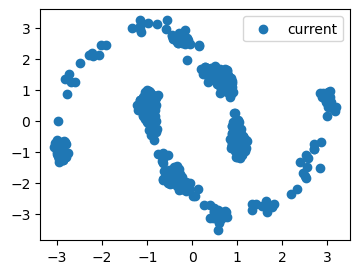

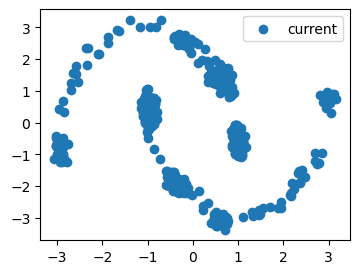

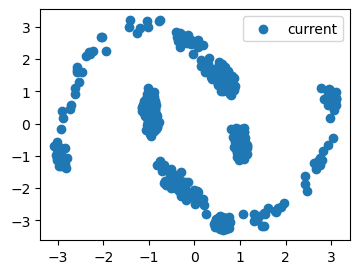

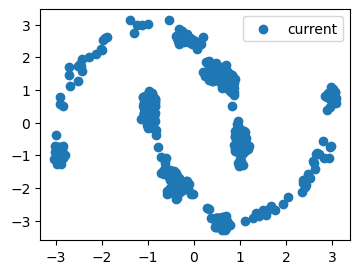

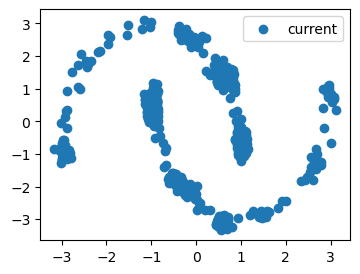

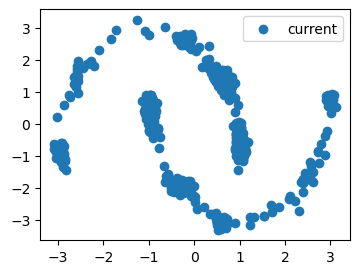

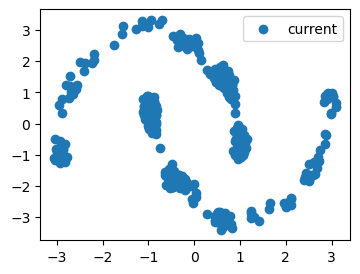

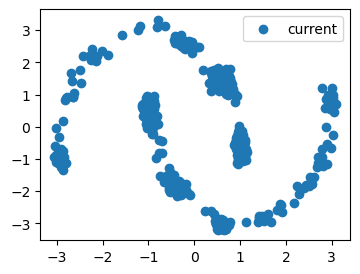

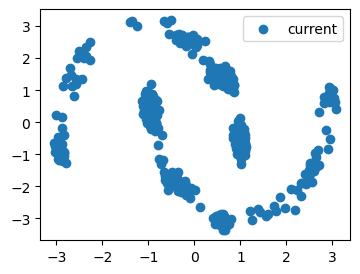

In [90]:
step_size = 0.001
x = torch.zeros(1024, 2)
x = torch.randn_like(x)
x_true = sampler.sample(1024)[0]


for i in range(3001):
    step_size = 0.01 * (0.1 ** (i / 3000))
    if i % 250 == 0:
        plt.figure(figsize=(4, 3))
        scatter(x.detach(), label='current')
        # scatter(x_true.detach(), alpha=0.1, label='true')
        plt.legend()
        plt.show()


    
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    x = x - 0.5 * step_size * grad + torch.randn_like(x) * math.sqrt(step_size)
    


In [110]:
big_sample = sampler.sample(2048 * 2)[0]
def target(x):
    gmm = GaussMix(big_sample, torch.ones_like(big_sample) * 0.002)
    return - gmm.log_prob(x)

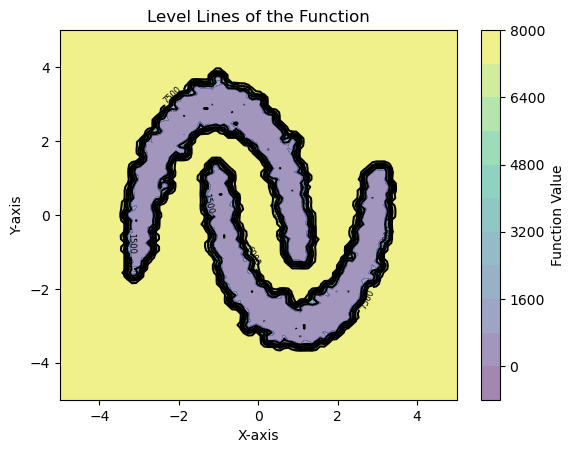

In [116]:
draw_level_lines(lambda x: target(x).clamp(max=8000), lims=(-5, 5))

In [122]:
energy = Energy(in_dim=2, out_dim=1, 
                hidden_dim=256, 
                n_blocks=1, 
                use_ln=False, 
                block_type='simple')
energy_optim = torch.optim.Adam(energy.parameters(), lr=2e-4)

In [146]:
energy_optim.param_groups[0]['lr'] = 5e-3

It=0, loss=1313.374


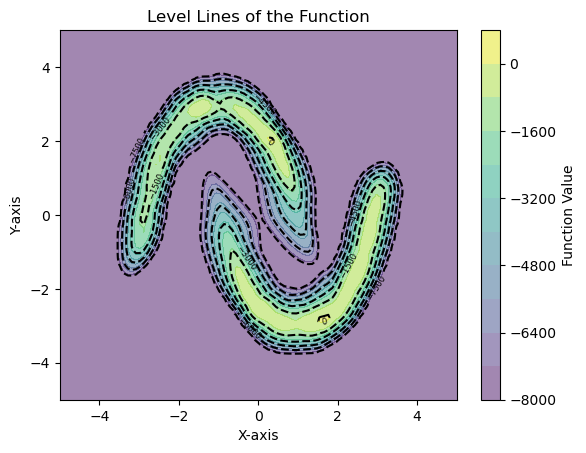

It=1000, loss=905.913


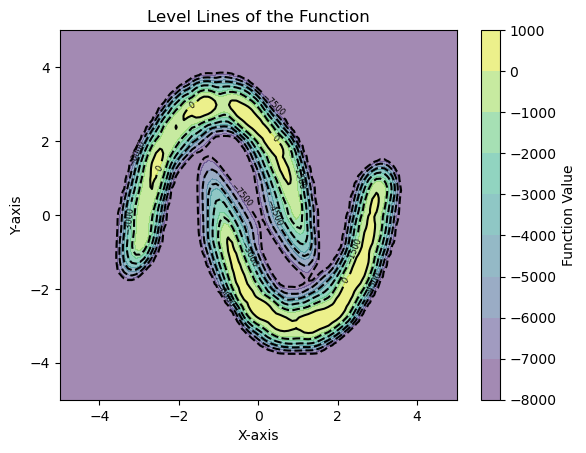

It=2000, loss=834.445


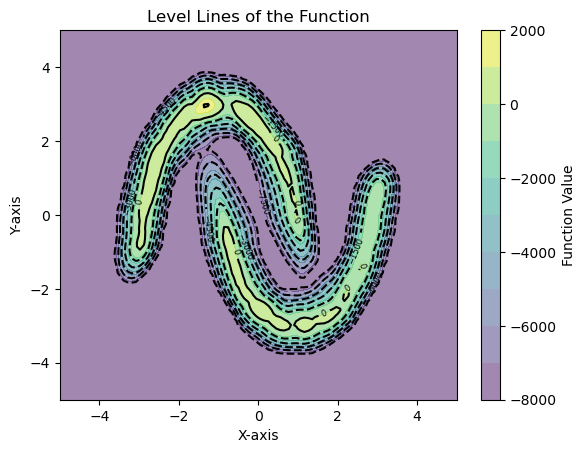

It=3000, loss=595.011


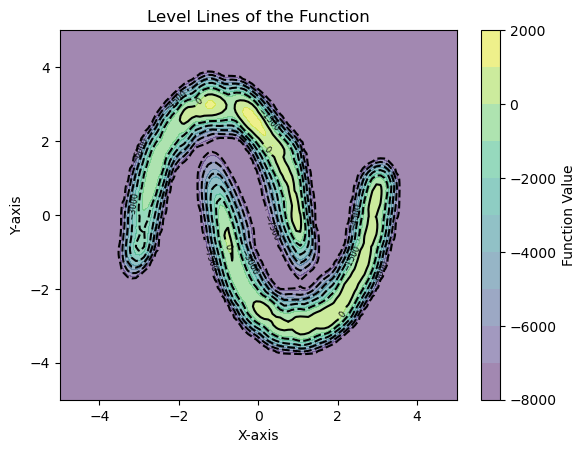

It=4000, loss=626.916


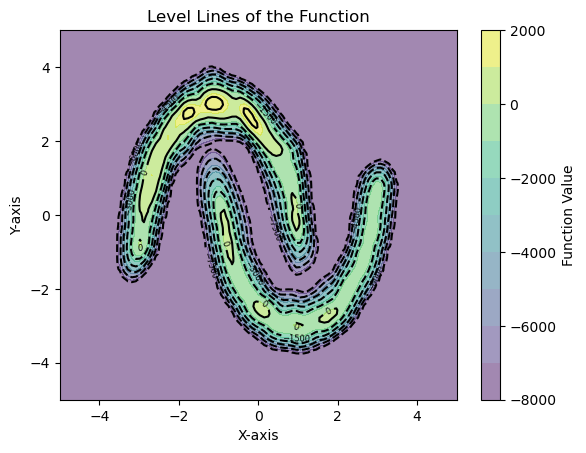

It=5000, loss=528.927


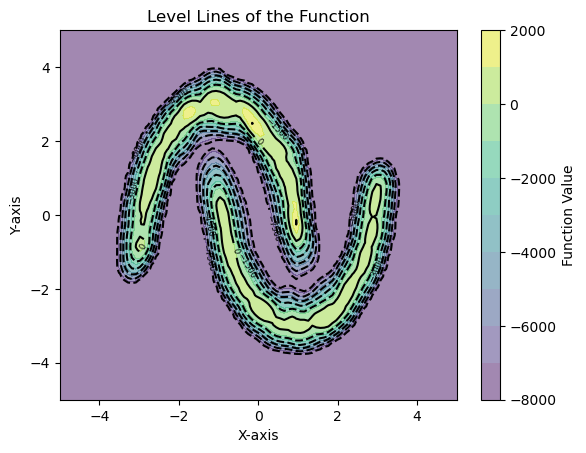

It=6000, loss=430.236


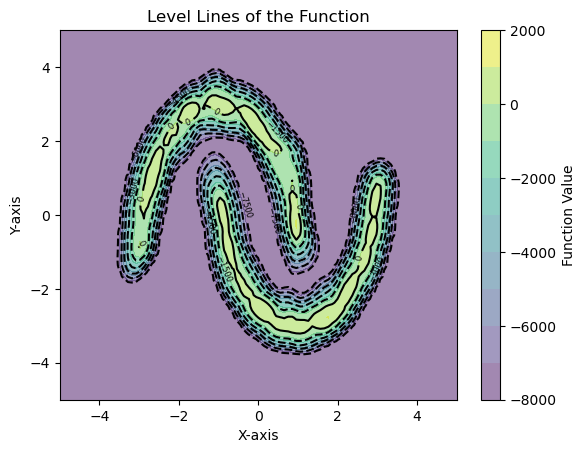

It=7000, loss=447.656


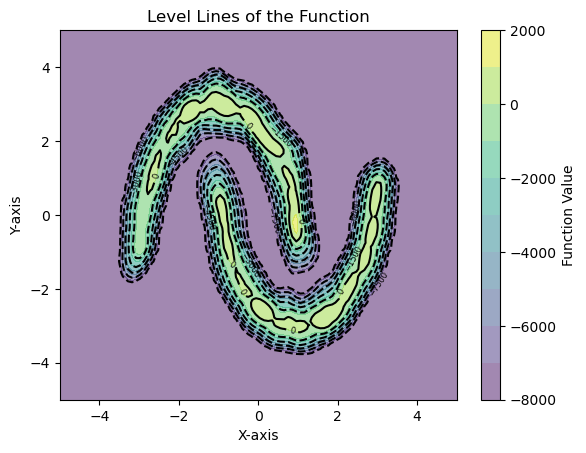

KeyboardInterrupt: 

In [147]:
for it in range(50_000):
    x = torch.rand(2048, 2) * 10 - 5

    e = energy(x)
    t = target(x)
    loss = (torch.where((t > 8e3) & (e > 8e3), torch.tensor(0.0), torch.tensor(1.0)) * torch.abs(e - t)).mean()
    
    energy_optim.zero_grad()
    loss.backward()
    energy_optim.step()
    
    if it % 1000 == 0:
        print(f'It={it}, loss={loss.item():.3f}')
        draw_level_lines(lambda x: - energy(x).clamp(max=8000), lims=(-5, 5))
        plt.show()


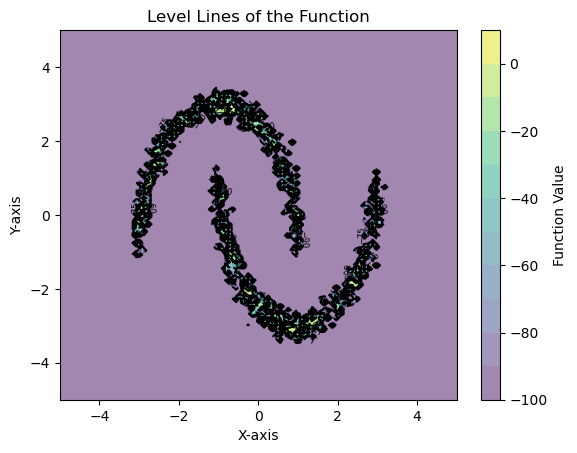

In [145]:
draw_level_lines(lambda x: - target(x).clamp(max=100), lims=(-5, 5))
plt.show()

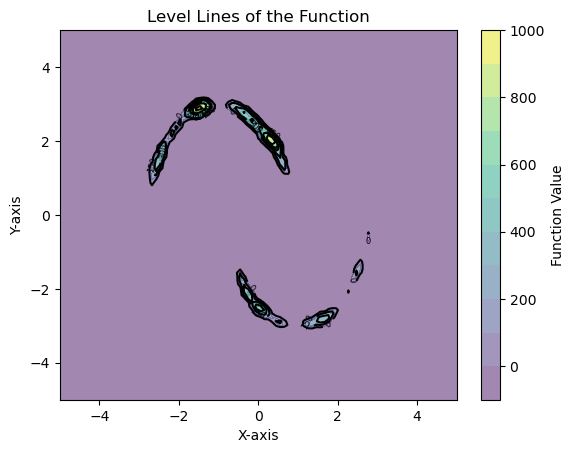

In [144]:
draw_level_lines(lambda x: - energy(x).clamp(max=100), lims=(-5, 5))
plt.show()

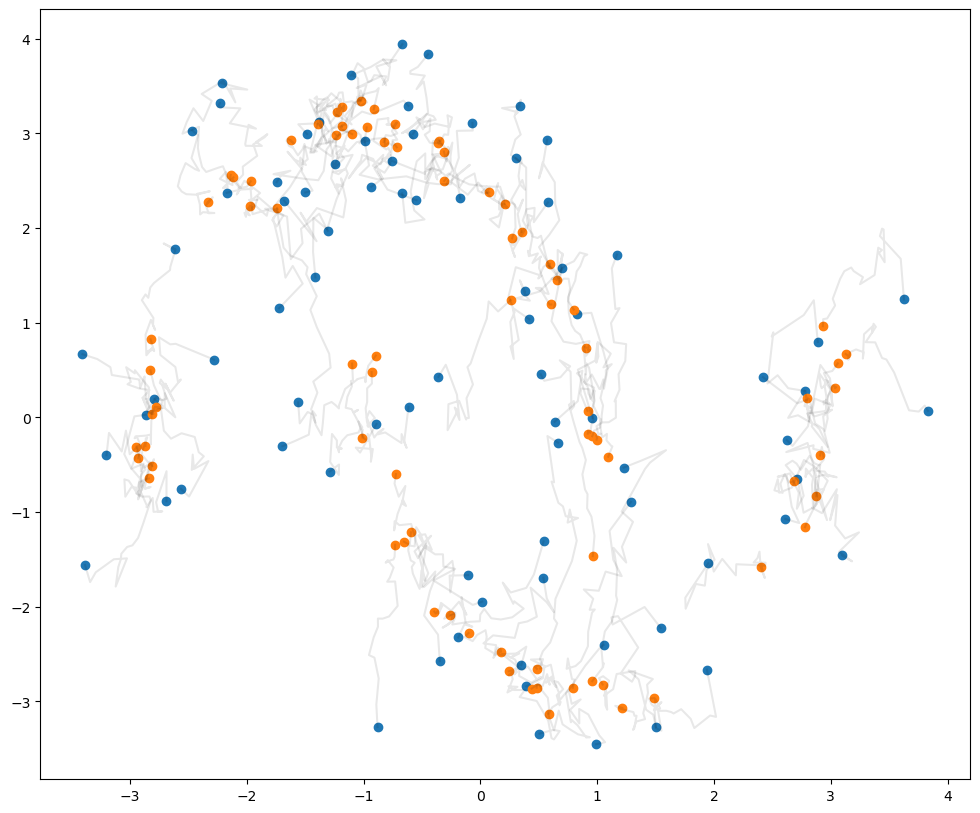

In [83]:
plt.figure(figsize=(12, 10))

n_traj = 80
x_0, x_1, traj = fwd_trajectory[0], fwd_trajectory[-1], np.array(fwd_trajectory).swapaxes(0, 1)
scatter(x_0[:n_traj], label='x_0')
scatter(x_1[:n_traj], label='x_1')

for x in traj[:n_traj]:
    plt.plot(x[:, 0], x[:, 1], color='black', alpha=0.09)

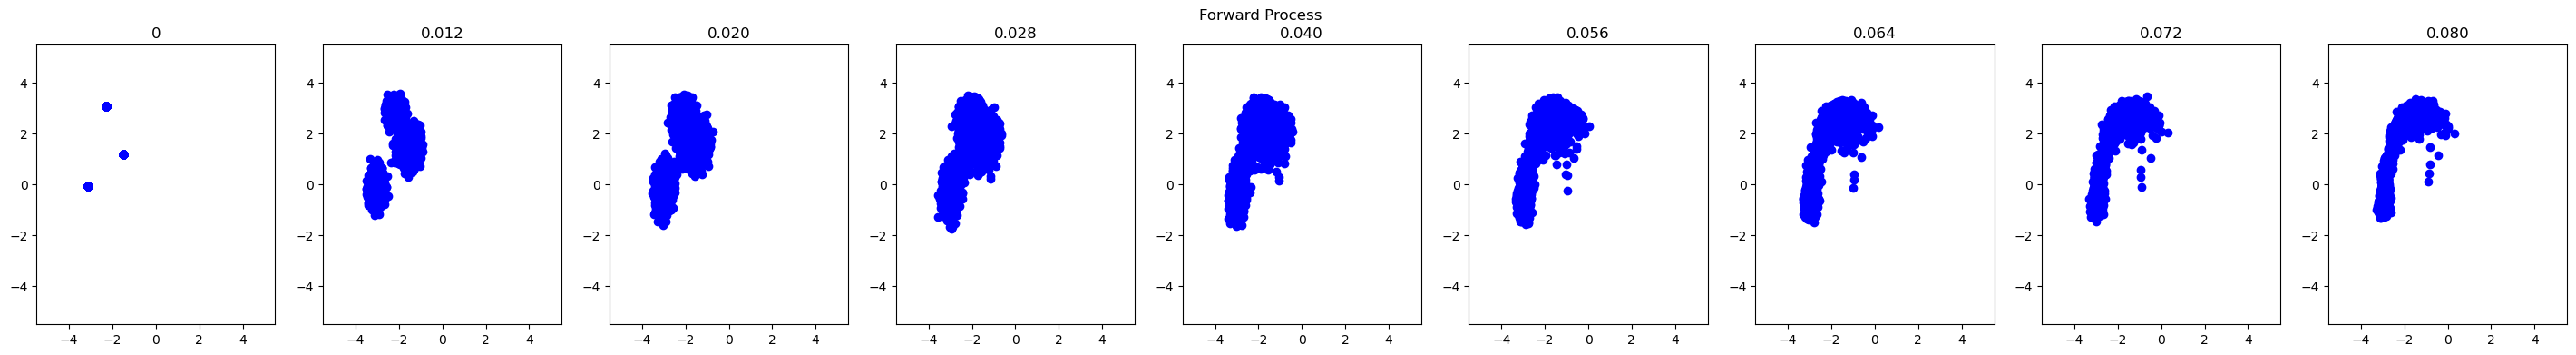

In [88]:
x_0, _ = sampler.sample(8)
x_0 = x_0[:3]
x_0 = x_0 + torch.randn_like(x_0) * noise_std

x_0 = x_0.repeat(2000, 1)

with torch.no_grad():
    fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", dt, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(fwd_trajectory, timesteps, 
                    indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title="Forward Process",
                    limits=(-5.5, 5.5))


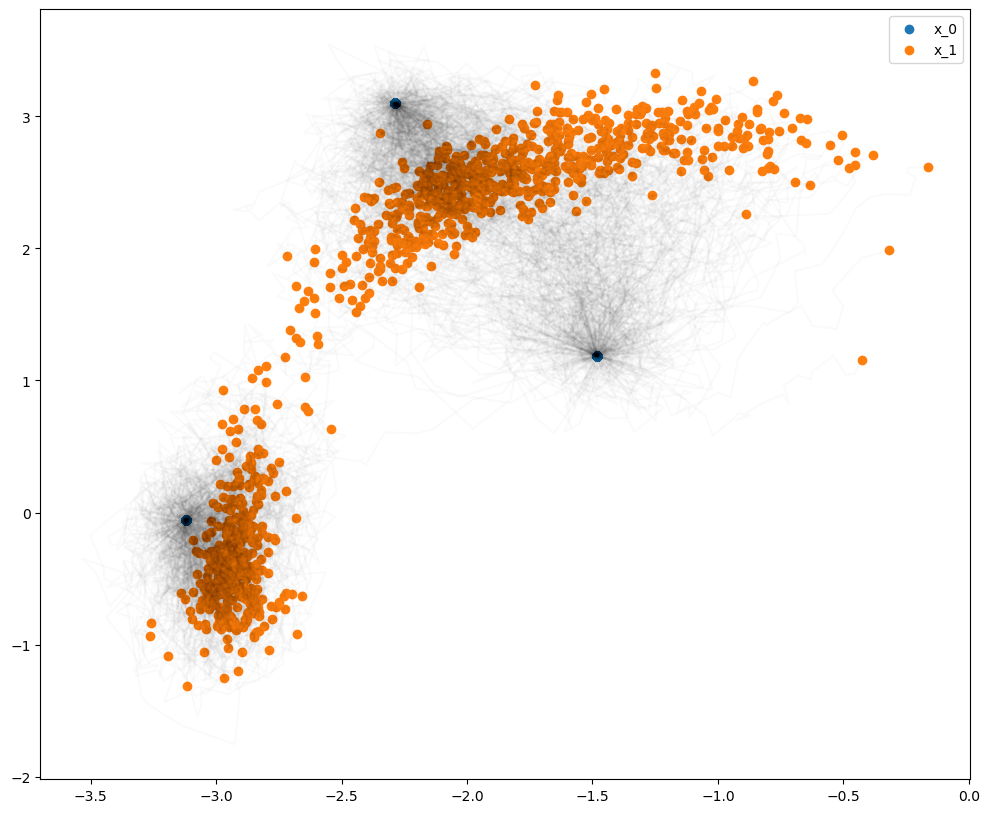

In [89]:
plt.figure(figsize=(12, 10))

n_traj = 1000
x_0, x_1, traj = fwd_trajectory[0], fwd_trajectory[-1], np.array(fwd_trajectory).swapaxes(0, 1)
scatter(x_0[:n_traj], label='x_0')
scatter(x_1[:n_traj], label='x_1')

for x in traj[:n_traj]:
    plt.plot(x[:, 0], x[:, 1], color='black', alpha=0.02)
plt.legend()